In this project, we will explore how to implement image classification using machine learning. It demonstrates the implementation of Cat-Dog image classification by using logistic regression. The dataset is available in kaggle https://www.kaggle.com/datasets/tongpython/cat-and-dog

**Import nessessary library**

In [117]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

**Data Preprocessing**

In [118]:
# Function to preprocess images
def preprocess_image(image_path, target_size=(128, 128)):
    img = Image.open(image_path).convert('RGB')  # Convert to grayscale
    img = img.resize(target_size)             # Resize to target size
    img_array = np.array(img)                 # Convert to numpy array
    return img_array / 255.0        # Normalize and flatte

This function is designed for preprocessing an input image. It performs several key operations. First, the image is read into the program, and then it is resized to the desired dimensions. Next, the image is converted into a numpy array format, which is essential for numerical operations in Python. Finally, the values in the array are normalized to a range between 0 and 1, which is a common practice in image processing to ensure uniformity and better performance during analysis or training.

**Load Dataset**

In [119]:
import os  # Provides a way of interacting with the operating system's file system
import numpy as np  # Used for creating and manipulating arrays

def load_dataset(data_dir, categories, target_size=(128, 128)):
    images, labels = [], []  # Initialize empty lists to store image data and labels
    valid_extensions = ('.png', '.jpg', '.jpeg')  # Define valid image file extensions

    for category in categories:  # Loop through each category in the dataset
        category_dir = os.path.join(data_dir, category)  # Construct the path to the category directory
        for file_name in os.listdir(category_dir):  # Iterate over each file in the category directory
            # Skip hidden/system files or files with invalid extensions
            if file_name.startswith('.') or not file_name.lower().endswith(valid_extensions):
                continue  # Skip to the next file
            
            file_path = os.path.join(category_dir, file_name)  # Construct the full path to the file
            try:
                # Preprocess the image (e.g., resize it) and convert it to a usable array
                img_array = preprocess_image(file_path, target_size)
                images.append(img_array)  # Add the processed image to the images list
                labels.append(category)  # Add the corresponding category label to the labels list
            except Exception as e:
                # Print an error message if the image fails to load or preprocess
                print(f"Error loading image {file_path}: {e}")

    # Convert the images and labels lists to NumPy arrays for easier manipulation and processing
    return np.array(images), np.array(labels)

Loading a dataset is a crucial step in data preparation, particularly for deep learning tasks. In this case, the data consists of images, and its structure plays a significant role in the processing pipeline. The primary goal of this function is to transform raw images into a standardized format of [batch, width, height, channel], which aligns with the conventions used in PyTorch. By doing so, it enables batch training, a standard practice in most popular deep learning frameworks, ensuring efficiency and scalability during the training process.

In [ ]:
# Note that the path will be different on your environment.

training_path = "/datasets/tongpython/cat-and-dog/versions/1/training_set/training_set/"

testing_path = "/datasets/tongpython/cat-and-dog/versions/1/test_set/test_set/"


categories = ['cats','dogs']

# Load and preprocess data
print("Loading dataset...")
X, y = load_dataset(training_path, categories)

X_test, y_test = load_dataset(training_path, categories)

print('Completed')

Loading dataset...
Completed


In [121]:
# Checking the shape of the data

print(X.shape)
print(y.shape)

(8005, 128, 128, 3)
(8005,)


In [122]:
# Checking labels
y[4000]

'dogs'

**Simple Visualization**

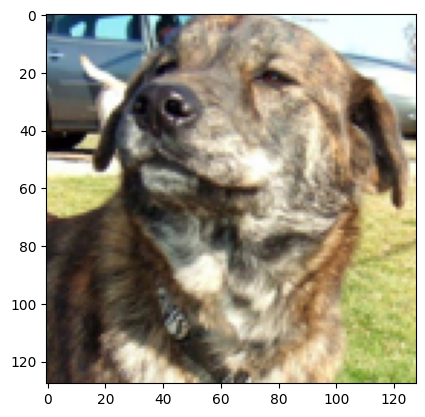

In [123]:
img_ex = X[4000,:,:,:] # Select the 4000th image to visualize
plt.imshow(img_ex)
plt.show()

**Feature Extraction**

In the context of machine learning and data science, features are measurable properties or characteristics of the data that are used as input for a model to learn patterns and make predictions. Think of features as the building blocks that help a machine learning algorithm understand the problem it’s solving.

Types of Features
- Numerical Features: Quantitative values that represent a measurable quantity.
  Example: Age, temperature, height, or income.
- Categorical Features: Qualitative values that represent categories or groups.
  Example: Gender (male/female), color (red/blue/green).
- Ordinal Features: Features with a clear, ordered relationship between values.
  Example: Education level (high school < bachelor's < master's).
- Textual Features: Features derived from text, often processed into numerical vectors using techniques like TF-IDF, word embeddings, or     bag of words.
  Example: Sentences, reviews, or documents.
- Image/Pixel Features: Features extracted from images, such as pixel values or higher-level characteristics like edges or textures.
  Example: RGB values or convolutional neural network outputs.
- Time-Series Features: Features that vary over time, often used in forecasting and sequential data problems.
  Example: Stock prices over time, heart rate data.

Characteristics of Good Features
Good features:
- Relevant: Directly related to the target variable.
- Discriminative: Help in distinguishing between classes or categories.
- Independent: Ideally uncorrelated with each other to reduce redundancy.
- Scalable: Compatible with the algorithms used (e.g., normalized for models sensitive to magnitude).

In [124]:
import cv2

def color_features(image_array):
    # Ensure the image is in uint8 format
    if image_array.dtype != np.uint8:
        image_array = (image_array * 255).astype(np.uint8) if image_array.dtype == np.float32 else image_array.astype(np.uint8)
    
    # Ensure the image has 3 channels (RGB)
    if len(image_array.shape) != 3 or image_array.shape[2] != 3:
        raise ValueError("Input image must have 3 color channels (RGB).")
    
    # Calculate color histograms for each channel (B, G, R)
    hist_b = cv2.calcHist([image_array], [0], None, [16], [0, 256]).flatten()  # Blue
    hist_g = cv2.calcHist([image_array], [1], None, [16], [0, 256]).flatten()  # Green
    hist_r = cv2.calcHist([image_array], [2], None, [16], [0, 256]).flatten()  # Red

    # Combine histograms into a single feature vector
    features = np.hstack((hist_b, hist_g, hist_r))
    return features

The color_features function is designed to extract color histogram features from an input RGB image, providing a numerical representation of the image's color distribution. The function first ensures the input image is in the correct format by converting it to uint8 if necessary and verifies that the image has three color channels (RGB). It then calculates histograms for each channel (Blue, Green, and Red) using 16 bins to capture the distribution of pixel intensities within the range of 0 to 255. These histograms, which represent the frequency of pixel values for each channel, are flattened into 1D arrays and concatenated into a single feature vector. This vector serves as a compact representation of the image's color characteristics, making it suitable for tasks like image classification, clustering, or content-based image retrieval. By standardizing the extraction process, the function ensures compatibility and efficiency in various computer vision workflows.

In [136]:
# Applying feature extraction
X_train = np.array([color_features(X[i, :, :, :]) for i in range(X.shape[0])])
y_train = y
print(X_train.shape)

(8005, 48)


In [137]:
# Applying feature extraction through 
X_test = np.array([color_features(X[i, :, :, :]) for i in range(X_test.shape[0])])
print(X_test.shape)

(8005, 48)


**Shape Summary**

In [138]:
print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_test : {y_test.shape}')

X_train : (8005, 48)
y_train : (8005,)
X_test : (8005, 48)
y_test : (8005,)


**Training**

In [139]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train Random Forest model
print("Training Random Forest...")
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)  # 100 trees by default
random_forest_model.fit(X_train, y_train_encoded)

# Evaluate the model
print("Evaluating model...")
y_pred_encoded = random_forest_model.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)  # Decode predictions to original labels

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Training Random Forest...
Evaluating model...
Accuracy: 0.50
Classification Report:
              precision    recall  f1-score   support

        cats       0.00      0.00      0.00      4000
        dogs       0.50      1.00      0.67      4005

    accuracy                           0.50      8005
   macro avg       0.25      0.50      0.33      8005
weighted avg       0.25      0.50      0.33      8005



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Enhanced Feature**

In [140]:
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern

def enhanced_features(image_array):
    # Ensure the image is in uint8 format
    if image_array.dtype != np.uint8:
        image_array = (image_array * 255).astype(np.uint8) if image_array.dtype == np.float32 else image_array.astype(np.uint8)
    
    # Ensure the image has 3 channels (RGB)
    if len(image_array.shape) != 3 or image_array.shape[2] != 3:
        raise ValueError("Input image must have 3 color channels (RGB).")
    
    # 1. Color Features: Color Histograms
    hist_b = cv2.calcHist([image_array], [0], None, [16], [0, 256]).flatten()  # Blue
    hist_g = cv2.calcHist([image_array], [1], None, [16], [0, 256]).flatten()  # Green
    hist_r = cv2.calcHist([image_array], [2], None, [16], [0, 256]).flatten()  # Red
    color_features = np.hstack((hist_b, hist_g, hist_r))
    
    # 2. Texture Features: Local Binary Patterns (LBP)
    gray_image = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    radius = 3  # Neighborhood radius
    n_points = 8 * radius  # Number of points in the LBP
    lbp = local_binary_pattern(gray_image, n_points, radius, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= lbp_hist.sum()  # Normalize LBP histogram
    
    # 3. Shape and Texture Features: Simplified HOG
    gray_image_resized = cv2.resize(gray_image, (64, 64))  # Smaller size for faster computation
    hog_features = hog(
        gray_image_resized, 
        orientations=6,  # Fewer gradient orientations
        pixels_per_cell=(16, 16),  # Larger cells to reduce feature dimensionality
        cells_per_block=(1, 1),  # Simplified block size
        block_norm='L2-Hys', 
        visualize=False  # Skip visualization for efficiency
    )
    
    # Combine all features
    combined_features = np.hstack((color_features, lbp_hist, hog_features))
    return combined_features

In [141]:
# Applying feature extraction through the 
X_train = np.array([enhanced_features(X[i, :, :, :]) for i in range(X.shape[0])])
y_train = y
print(X_train.shape)

(8005, 170)


In [142]:
# Applying feature extraction through the 
X_test = np.array([enhanced_features(X[i, :, :, :]) for i in range(X_test.shape[0])])
print(X_test.shape)

(8005, 170)


In [143]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train Random Forest model
print("Training Random Forest...")
random_forest_model = RandomForestClassifier(n_estimators=50, random_state=42)  # 100 trees by default
random_forest_model.fit(X_train, y_train_encoded)

# Evaluate the model
print("Evaluating model...")
y_pred_encoded = random_forest_model.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)  # Decode predictions to original labels

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Training Random Forest...
Evaluating model...
Accuracy: 0.72
Classification Report:
              precision    recall  f1-score   support

        cats       0.66      0.91      0.76      4000
        dogs       0.85      0.53      0.65      4005

    accuracy                           0.72      8005
   macro avg       0.76      0.72      0.71      8005
weighted avg       0.76      0.72      0.71      8005



**CONCLUSION**

The findings show that color characteristics alone are insufficient for differentiating between cats and dogs because they can miss the texture or form variations that are essential for categorization. Combining color, LBP, and HOG characteristics gives the model a more comprehensive representation of the pictures by include edge orientation patterns (HOG) and texture (LBP) in addition to color information. This results in a notable improvement in performance, enhancing memory and precision for "cats" and attaining greater balance overall.